In [273]:
from keras import Sequential
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPool2D, Flatten, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [5]:
dataset = {}
files = ['test-img.data', 'test-label.data', 'train-img.data', 'train-label.data']
for file in files:
    with open('../mnist-dataset/'+file, 'rb') as f:
        data = f.read()
        dataset[file[:-5]] = data

In [180]:
# 整理数据

def convert_to_one_hot(y, C):
    return np.eye(C, dtype=np.uint8)[y.reshape(-1)]

testImg = np.fromiter(dataset['test-img'][16:], np.float)
X_test = testImg.reshape([-1, 28, 28, 1])/255.0 - 0.5

trainImg = np.fromiter(dataset['train-img'][16:], np.float)
trainImg = trainImg.reshape([-1, 28, 28, 1])/255.0 - 0.5

testLabel = np.fromiter(dataset['test-label'][8:], np.uint8)
Y_test = convert_to_one_hot(testLabel, 10)

trainLabel = np.fromiter(dataset['train-label'][8:], np.uint8)
trainLabel = convert_to_one_hot(trainLabel, 10)

validRatio = 0.1
validLen = int(validRatio * len(trainImg))
X_valid, X_train = trainImg[:validLen], trainImg[validLen:]
Y_valid, Y_train = trainLabel[:validLen], trainLabel[validLen:]

In [358]:
# 构建卷积网络

model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), batch_input_shape=(None, 28, 28, 1)))
model.add(Activation('relu'))

model.add(Conv2D(16, kernel_size=(3,3), strides=2))
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(BatchNormalization())


model.add(Conv2D(32, kernel_size=(3,3)))
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 26, 26, 8)         80        
_________________________________________________________________
activation_118 (Activation)  (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 12, 12, 16)        1168      
_________________________________________________________________
activation_119 (Activation)  (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 6, 6, 16)          0         
_________________________________________________________________
batch_normalization_132 (Bat (None, 6, 6, 16)          64        
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 4, 4, 32)          4640      
__________

In [335]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.15, height_shift_range=0.15, zoom_range=0.15)
datagen.fit(X_train)

In [369]:
model.fit(X_train, Y_train,
          batch_size=256, epochs=10, verbose=1,
          validation_data=(X_valid, Y_valid), shuffle=True)
# model.fit_generator(datagen.flow(X_train, Y_train, batch_size=256),
#                     steps_per_epoch=len(X_train)/10, epochs=5, validation_data=(X_valid, Y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 10s 185us/step - loss: 0.0137 - val_loss: 0.0486
Epoch 2/10
54000/54000 [==============================] - 10s 185us/step - loss: 0.0134 - val_loss: 0.0484
Epoch 3/10
54000/54000 [==============================] - 10s 184us/step - loss: 0.0135 - val_loss: 0.0484
Epoch 4/10
54000/54000 [==============================] - 10s 185us/step - loss: 0.0132 - val_loss: 0.0484
Epoch 5/10
54000/54000 [==============================] - 10s 185us/step - loss: 0.0131 - val_loss: 0.0483
Epoch 6/10
54000/54000 [==============================] - 10s 185us/step - loss: 0.0129 - val_loss: 0.0481
Epoch 7/10
54000/54000 [==============================] - 10s 185us/step - loss: 0.0127 - val_loss: 0.0483
Epoch 8/10
54000/54000 [==============================] - 10s 184us/step - loss: 0.0123 - val_loss: 0.0481
Epoch 9/10
54000/54000 [==============================] - 10s 184us/step - loss: 0.0124 - val_l

In [370]:
p = model.predict(X_test, verbose=1)
accu = np.argmax(p, axis=1) == np.argmax(Y_test, axis=1)
sum(accu) / len(accu)

10000/10000 [==============================] - 1s 138us/step


0.9873

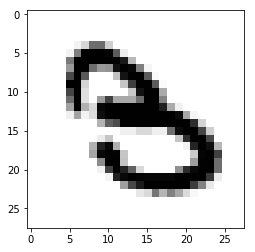

In [295]:
plt.imshow(X_test[18].reshape(28, 28), cmap='binary')

In [372]:
np.argmin(accu)

18

In [373]:
print(np.argmax(p[18]))
print(np.argmax(Y_test[18]))

8
3


In [374]:
model.save('conv-mnist.hdf5')